###The idea Behind this Project is to perform analysis on latent space created by a transformer. Database used for this purpose is DIT scientific papers data that contains information about papers published by professionals working at DIT. Bert algorithm is used to create the latent space, since it is a encoder only transformer. After that, eucledian distance is used to calculate the distance between the papers published by different authors to find the authors who might be working in the same areas but are not coauthors. Then K-means is applied on the latent space to group similar points in latent space together and study the result. Below is the inspiration for the project
https://jas.bayern/index.php/bjas/article/view/135

In [1]:
!pip install sentence-transformers
!pip install keybert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import json
import pandas as pd
import heapq
from sklearn.cluster import KMeans
import numpy as np
from keybert import KeyBERT
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Here the data is extracted and pre processed

In [3]:
with open(f"scientific-papers.json", "r") as json_file:
            metadata = json.load(json_file)

df = pd.DataFrame(metadata)
df = df.rename(columns={'id': 'paper_id'})

selected_columns = ['paper_id','title', 'referenceAuthors','date', 'abstractText']
df_temp = df[selected_columns]

selected_columns = ['paper_id','abstractText']
filtered_df = df[selected_columns]
filtered_df = filtered_df.dropna(subset=['abstractText'])
max_length = 512
filtered_df = filtered_df[filtered_df['abstractText'].str.split().str.len() <= max_length]

print(len(filtered_df))


1493


In [4]:
def has_matching_id(item, target_id):
  for element in item:
    if element["person"]["id"] == target_id:
      return True
  return False

In this part of the code, a list of unique author ids is made. Also a dictionary is made that stores the information about co authors. The dictionary is created such that key is author id and value is list of authors ids such that the author ids in the value are of higer alpha numeric than in the key. This helps reducing the total size of the dictionary by eliminating redundancy and reduces the number of comparisons. It also exploits the hashing property of dictionaries in python

In [5]:
ids=[]
author_firstname={}
author_secondname={}
coauthor_pairs_dict={}

for row in df_temp["referenceAuthors"]:
  rowLen=len(row)
  for author in range(rowLen):
    id = row[author]["person"]["id"]
    author_firstname[id]=row[author]["person"]["firstname"]
    author_secondname[id]=row[author]["person"]["lastname"]
    ids.append(id)

    if author<rowLen-1:
      for i in range (author+1,rowLen):
        idnext=row[i]["person"]["id"]
        coauthor_pairs_list=coauthor_pairs_dict.get(min(id, idnext),[])
        if max(id, idnext) not in coauthor_pairs_list:
          coauthor_pairs_list.append(max(id, idnext))
          coauthor_pairs_dict[min(id, idnext)]=coauthor_pairs_list




uniqueIds=set(ids)

This code creates a dictioanry that contains authors and papers written by them

In [6]:
author_papers = {}


for id in uniqueIds:
  tempDF = df_temp[df_temp["referenceAuthors"].apply(lambda x: has_matching_id(x, id))]
  author_papers[id]=tempDF["paper_id"]

In [7]:
df_dict={}
for index, row in filtered_df.iterrows():
  df_dict[row[0]]=row[1]

Here latent space of the papers is being created. Abstract of the paper is being used to create the the latent space to try find different areas a paper might deal with

In [8]:
bert_model = SentenceTransformer("bert-base-uncased")
encodings ={}

encodings_indexes={}
encodings_list=[]
encodings_abstract=[]
for item in df_dict:
    encoding = bert_model.encode(df_dict[item])
    encodings_abstract.append(df_dict[item])
    encodings[item]=encoding
    encodings_indexes[item]=len(encodings_list)
    encodings_list.append(encoding)

encoding_string = " ".join([str(num) for num in encodings_list])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Function to calculate Euclidean Distance

In [9]:
def euclidean_distance(point1, point2):

  squared_differences = np.square(point1 - point2)

  sum_squared_differences = np.sum(squared_differences)

  return np.sqrt(sum_squared_differences)

This function checks if the second author is nearer that other authors already present in the first author list. If yes, it returns true with info of the author with longest distance

In [10]:
def check_if_nearer(nearest_authors_list,distance):
  maxVal=0
  maxValElement=[]
  for j in nearest_authors_list:
    if j[1]>maxVal:
      maxVal=j[1]
      maxValElement=j
  if distance<maxVal:
    return True, maxValElement
  else:
    return False, maxValElement


This fuction checks the distance between all pair of authors. A filter is applied so that it does not consider co authors. It returns a dictionary that contains the 5 closest authors to every other author

In [11]:
def total_author_distance(paper_latent_space, author_papers,coauthor_pairs_dict, num_neighbors=5):


  nearest_authors_dict={}

  for author1_id, author1_papers in author_papers.items():
    for author2_id, author2_papers in author_papers.items():
      if (author1_id == author2_id) or (max(author1_id, author2_id) in coauthor_pairs_dict.get(min(author1_id, author2_id),[])):
        continue

      total_distance = 0.0

      for paper1_id in author1_papers:
        if paper1_id not in paper_latent_space:
          continue

        for paper2_id in author2_papers:
          if paper2_id not in paper_latent_space:
            continue
          paper1_latent = paper_latent_space[paper1_id]
          paper2_latent = paper_latent_space[paper2_id]
          distance = euclidean_distance(paper1_latent, paper2_latent)

          total_distance += distance

      nearest_authors_list=nearest_authors_dict.get(author1_id,[])
      if len(nearest_authors_list)<num_neighbors:
        nearest_authors_list.append((author2_id,distance))
        nearest_authors_dict[author1_id]=nearest_authors_list
      else:
        checkNear=check_if_nearer(nearest_authors_list,distance)
        if checkNear[0]:
          nearest_authors_list.remove(checkNear[1])
          nearest_authors_list.append((author2_id,distance))
          nearest_authors_dict[author1_id]=nearest_authors_list

      nearest_authors_list=nearest_authors_dict.get(author2_id,[])
      if len(nearest_authors_list)<num_neighbors:
        nearest_authors_list.append((author1_id,distance))
        nearest_authors_dict[author2_id]=nearest_authors_list
      else:
        checkNear=check_if_nearer(nearest_authors_list,distance)
        if checkNear[0]:
          nearest_authors_list.remove(checkNear[1])
          nearest_authors_list.append((author1_id,distance))
          nearest_authors_dict[author2_id]=nearest_authors_list

  return nearest_authors_dict

In [16]:
closest_neighbors = total_author_distance(encodings, author_papers,coauthor_pairs_dict)

This function takes an author ID and returns n Authors(who are not co authors) closest to the author. The purpose is to find n authors who have not worked with the current author but work in the related fields. They might like to dicuss their work and ideas and may like to collabrate on a project.

In [17]:
def recommend_Author(closest_neighbors, author_ID):

  clos_neighborauthors=[]

  for author in closest_neighbors[author_ID]:
    #print(author)
    name=author_firstname[author[0]] + " " + author_secondname[author[0]]
    clos_neighborauthors.append(author_firstname[author[0]] + " " + author_secondname[author[0]])
  print("professor " + author_firstname[author_ID] + " "+ author_secondname[author_ID]+ " should have cofee with following professors")
  for i in clos_neighborauthors:
    print(i)

In [18]:
recommend_Author(closest_neighbors, 'fce34bd4-660d-024c-9b36-72a1644c5ab0')

professor A. Vlaskin should have cofee with following professors
J. Wittmann
R. Marschallinger
A. Puszer
W. Pamler
E. Trinka


Here K means is applied to the latent space of the papers. The point is to cluster papers which are similar in topics

In [19]:
all_embeddings = np.vstack([value for value in encodings_list])
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(all_embeddings)
cluster_labels = kmeans.labels_

In [20]:
keybert_model = KeyBERT(model="all-MiniLM-L6-v2")
keywords_dict={}

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Here latent space of the papers which are in same clusters is concatenated

In [21]:
cluster_dict={}
cluster_dict[0]=''
cluster_dict[1]=''
cluster_dict[2]=''
cluster_dict[3]=''
cluster_dict[4]=''
encodings_abstract
for i in range(len(cluster_labels)):
  if cluster_labels[i]==0:
    cluster_dict[0]=cluster_dict[0]+" "+encodings_abstract[i]
  elif cluster_labels[i]==1:
    cluster_dict[1]=cluster_dict[1]+" "+encodings_abstract[i]
  elif cluster_labels[i]==2:
    cluster_dict[2]=cluster_dict[2]+" "+encodings_abstract[i]
  elif cluster_labels[i]==3:
    cluster_dict[3]=cluster_dict[3]+" "+encodings_abstract[i]
  elif cluster_labels[i]==4:
    cluster_dict[4]=cluster_dict[4]+" "+encodings_abstract[i]
  else:
    continue

Here keybert is used to extract keywords from each cluster's latent space

In [22]:
cluster_keywords = {}
for cluster in range(5):
  keywords = keybert_model.extract_keywords(cluster_dict[cluster], top_n=10)
  cluster_keywords[cluster] = keywords

Wordcloud is used to project the keywords extracted. As is visible in the result, related topics are clustered together

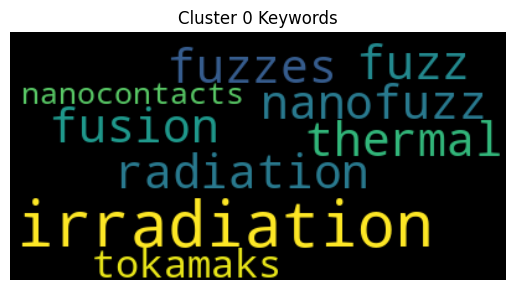

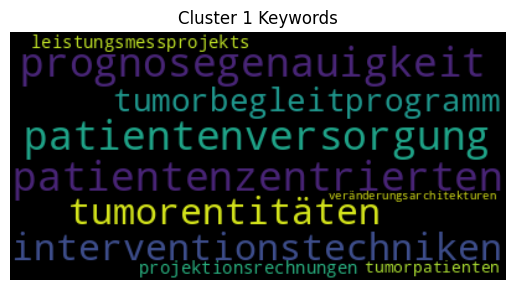

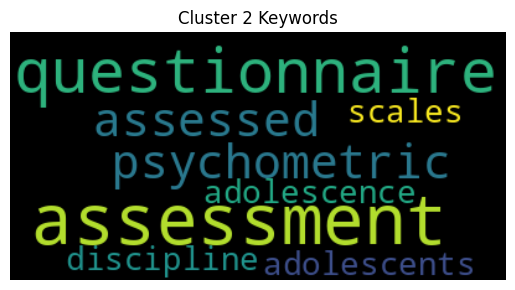

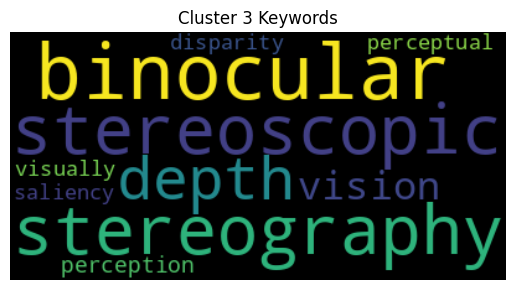

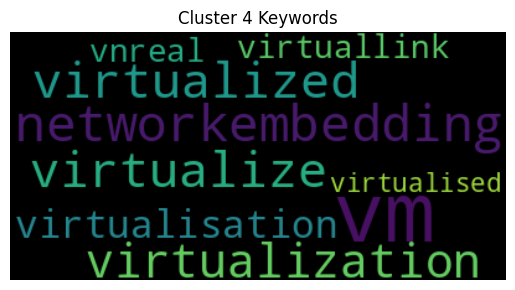

In [23]:
for cluster_id, keywords in cluster_keywords.items():
  wordcloud = WordCloud().generate(" ".join([kw[0] for kw in keywords]))

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f"Cluster {cluster_id} Keywords")
  plt.axis("off")
  plt.show()